# Forecasting da taxa de inadimplência
### Autor: Ángel Manuel Gálvez Límaco
O dataset utilizado neste projeto foi obtido do site público do Banco Central do Brasil. O objetivo é prever a taxa de inadimplência para os próximos 12 meses.

Importando algumas bibliotecas necessárias:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates

Importando a série temporal:

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r'C:\Users\Asus\Desktop\desafio\desafio_4int\bcdata.sgs.21082.csv', delimiter = ';')

In [3]:
df

,data,valor
0,01/03/2011,"3,17"
1,01/04/2011,"3,24"
2,01/05/2011,"3,37"
3,01/06/2011,"3,32"
4,01/07/2011,"3,42"
...,...,...
144,01/03/2023,"3,29"
145,01/04/2023,"3,48"
146,01/05/2023,"3,58"
147,01/06/2023,"3,56"


In [4]:
df.isnull().sum()

data     0
valor    0
dtype: int64

A primeira coluna da time series indica o més e a segunda coluna indica o valor percentual da carteira de crédito do Sistema Financeiro Nacional com pelo menos uma parcela com atraso superior a 90 dias. Esta taxa inclui operações contratadas no segmento de crédito livre e no segmento de crédito direcionado.

Podemos observar que os dados foram coletados entre marzo de 2011 e julio de 2023, ou seja, 149 meses. Assim, a base disponibilizada está completa.

Vejamos algumas informações uteis:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    149 non-null    object
 1   valor   149 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


A coluna data não está com o tipo date time e a coluna 'valor' é do tipo object. Vamos transformar esta última para o tipo numérico, um paso prévio necessário neste caso é substituir a vírgula pelo ponto para que possa ser reconhecido pelo compilador:

In [6]:
df.index = pd.to_datetime(df['data'], format='%d/%m/%Y')
df.drop(columns = ['data'], inplace = True)

df['valor'] = df['valor'].str.replace(',','.')
df['valor'] = df['valor'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149 entries, 2011-03-01 to 2023-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   valor   149 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


In [7]:
df.head()

,valor
data,
2011-03-01,3.17
2011-04-01,3.24
2011-05-01,3.37
2011-06-01,3.32
2011-07-01,3.42


Uma vez feitas as transformações básicas, podemos visualizar a time series para procurar tendências:

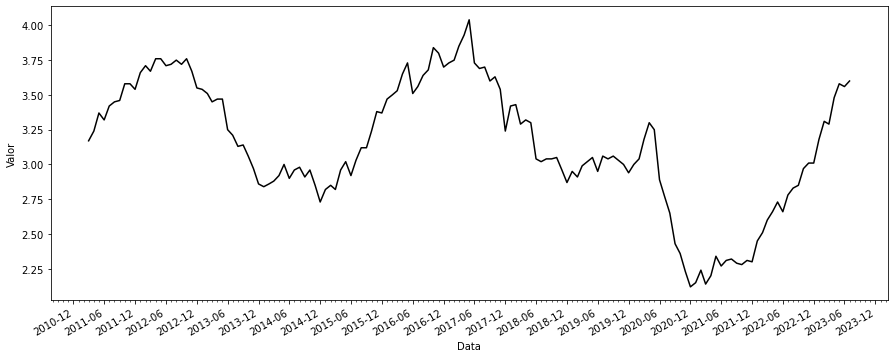

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))

#especificando os ticks no eixo x para uma melhor interpretação
monthly_locator = mdates.MonthLocator()
half_year_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)

year_month_formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(year_month_formatter)
plt.ylabel('Valor')
plt.xlabel('Data')

#plotando a time series
ax.plot(df.index, df['valor'],color = "black")

#rotação das lendas no eixo x
fig.autofmt_xdate()

A primeira observação evidente é que existe uma diminuição relativamente considerável da taxa de inadimplência entre junho de 2020 e junho de 2022. Curiosamente, é um intervalo de tempo que coincide com a pandemia. É um evento não vista em meses anteriores nesta time series. Porém, a partir de junho de 2022, a taxa de inadimplência tem incrementado, mas ainda não atingiu o máximo histórico observador em maio de 2017, quando a taixa foi 4.04.

In [9]:
#maior histórico observado
df[df.valor >=4]

,valor
data,
2017-05-01,4.04


In [10]:
#menor histórico observado
df[df.valor <= 2.25]

,valor
data,
2020-11-01,2.23
2020-12-01,2.12
2021-01-01,2.15
2021-02-01,2.24
2021-03-01,2.14
2021-04-01,2.20


A menor taxa observada foi 2.12 em dezembro de 2020.

Já que a time series já está pronto para ser usada no nosso modelo preditivo, vamos dividi-la em uma parte para treino e outra para teste. Já que temos 149 meses disponíveis, 45 meses serão usados para testar o modelo (aproximadamente 30%). Portanto a nossa base de teste comprende os meses desde novembro de 2019 até julho de 2023.

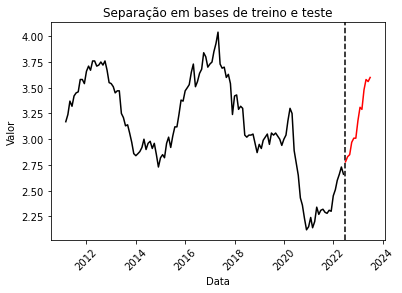

In [11]:
#separando a time series em treino e teste
treino = df[df.index < pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
teste = df[df.index >= pd.to_datetime("2022-07-01", format='%Y-%m-%d')]

#visualizando a time series para teste na cor vermelha
plt.axvline(x =  pd.to_datetime("2022-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.plot(treino, color = "black")
plt.plot(teste, color = "red")
plt.ylabel('Valor')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.title("Separação em bases de treino e teste")
plt.show()


Conferindo a quantidade de meses nas bases de treino e de teste:

In [12]:
teste.shape

(13, 1)

In [13]:
treino.shape

(136, 1)

## Análise prévia
Primeiramente, a descomposição multiplicativa e aditiva é feita para observar a existência de tendências na série temporal:

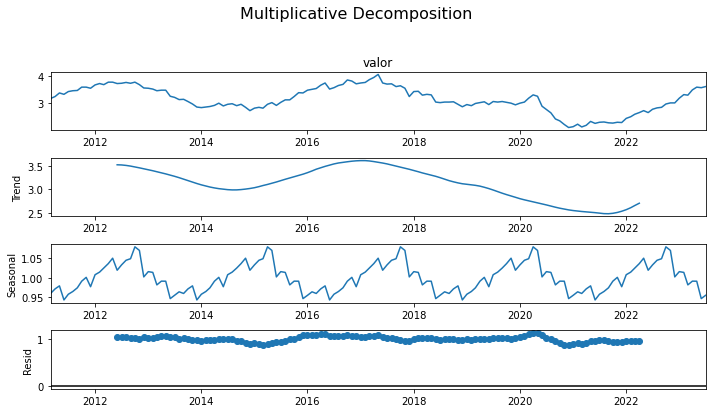

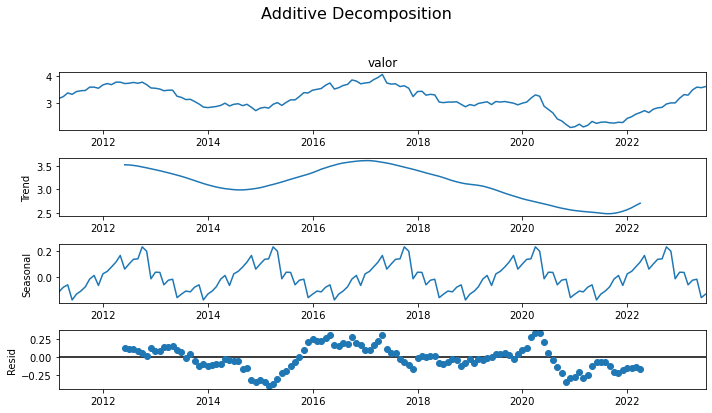

In [14]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['valor'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['valor'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

As descomposições evidenciam que a tendência da série temporal é oscilatória com uma queda considerável entre 2020 e 2022. Por outro lado, a sazonalizade e evidentemente anual. As flutuações correspondentes ao resíduo são mais evidentes na descomponsição multiplicativa, pois na descompisição aditiva, os resíduos são relativamente constante ao longo do tempo.

Um teste necessário é verificar a estacionariedade da série temporal:

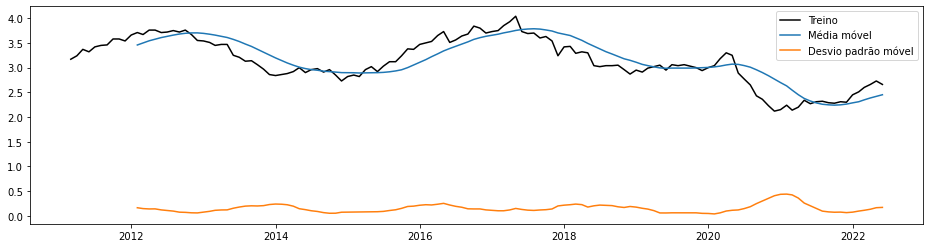

In [15]:
rolmean = pd.Series(treino['valor']).rolling(window=12).mean() 
rolstd = pd.Series(treino['valor']).rolling(window=12).std()
    
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(treino, color = 'black', label= 'Treino')
ax.plot(rolmean, label='Média móvel');
ax.plot(rolstd, label='Desvio padrão móvel');
ax.legend()

Visualmente, podemos afirmar que a média móvel varia considerávelmente ao longo do tempo, enquanto o desvio padrão móvel é quase constante. Para confirmar isto, vamos usar o teste de Dickey-Fuller (ADF):

In [16]:
dftest = adfuller(treino.dropna(), autolag='AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('P-value = {:.3f}'.format(dftest[1]))
print('Critical values :')
for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

Test statistic = -3.034
P-value = 0.032
Critical values :
	1%: -3.4846672514209773 - The data is not stationary with 99% confidence
	5%: -2.8853397507076006 - The data is  stationary with 95% confidence
	10%: -2.5794629869786503 - The data is  stationary with 90% confidence


O teste ADF indica que a série temporal não é estacionária com um 99% de confiança. Outros gráficos de bastante utilidade são a função de autocorrelação (ACF) e a função de autocorrelação parcial (PACF).

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


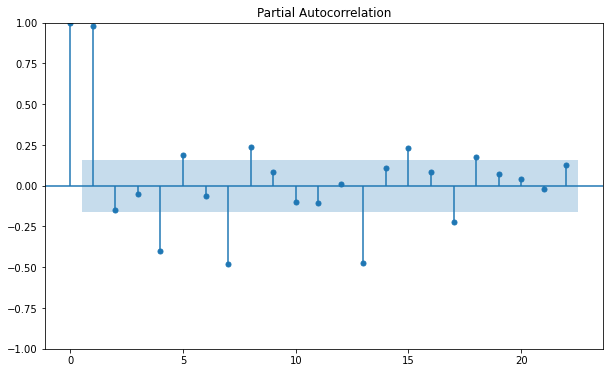

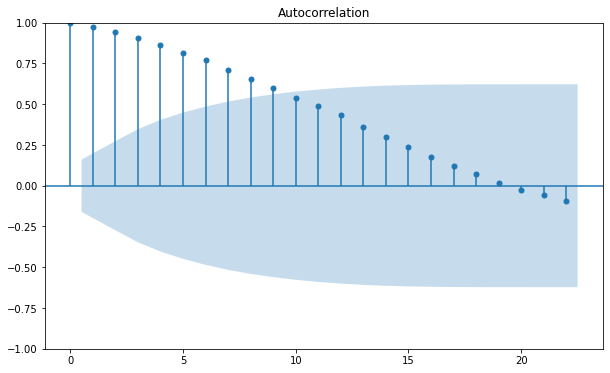

In [36]:
plot_pacf(df['valor']);
plot_acf(df['valor']);

Naturalmente, a autocorrelação em lag=0 é a maior possível. Observa-se também que após lag=9, a autocorrelação entra no intervalo de confiança. Por outro lado, levando em conta a PACF, ela é oscilante após lag=1, tendo alguns picos fora do intervalo de confiança, por exemplo en lag=4 e 7.

## Auto-regressão de médias móveis (ARMA)
Uma primeira tentativa como modelo de forecasting será ARMA. Lembre-se que usaremos a time series de treino para preparar o modelo e avaliaremos o seu performance na porção de teste.

Vamos utilizar o pacote SARIMAX para definir o modelo ARMA:

In [17]:
y_treino = treino['valor']

In [18]:
ARMAmodel = SARIMAX(y_treino, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Agora podemos usar o modelo criado para comparar as previsões com a série de teste:

In [19]:
y_pred_arma = ARMAmodel.get_forecast(len(teste.index))
y_pred_df_arma = y_pred_arma.conf_int(alpha = 0.05) 
y_pred_df_arma["Predictions"] = ARMAmodel.predict(start = y_pred_df_arma.index[0], end = y_pred_df_arma.index[-1])
y_pred_df_arma.index = teste.index
y_pred_out_arma = y_pred_df_arma["Predictions"] 

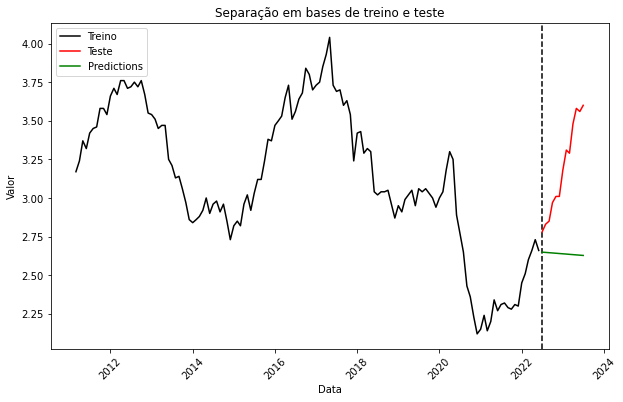

In [20]:
plt.axvline(x =  pd.to_datetime("2022-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.plot(treino, color = "black", label = 'Treino')
plt.plot(teste, color = "red", label = 'Teste')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.title("Separação em bases de treino e teste")
plt.plot(y_pred_out_arma, color='green', label = 'Predictions')
plt.legend()
plt.show()

Visualmente, podemos afirmar que as previsões desde julho de 2022 até julho de 2023 usando ARMA estão bastante longe dos dados reais. Vamos usar a métrica da raiz quadrática média dos erros (RMSE) para quantificar a qualidade das previsões:

In [21]:
arma_rmse = np.sqrt(mean_squared_error(teste['valor'].values, y_pred_df_arma["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  0.6247210520433266


Nosso modelo ARMA considera que entre julho de 2022 e julho de 2023, existirá uma pequena redução no valor da taxa de inadimplência. Porém, na realidade, a taxa aumenta nessa faixa de tempo. Assim, ARMA é uma opção bastante limitada nesta situação principalmente porque a sazonalidade e a estacionaridade da série são considerávelmente modificadas no período entre março de 2020 e dezembro de 2022. Fora dessa faixa de tempo, existe uma sazonalidade de aproximadamente quatro anos: a evolução da taxa de inadimplência é bastante similar entre 2012 e 2016 e 2016 e 2020.

## Auto-regressão de médias móveis (ARIMA)
Vamos agora usar ARIMA para tentar obter um forecasting aceitável:

In [22]:
ARIMAmodel = ARIMA(y_treino, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


O modelo criado será usado na base de treino para aprendizado:

In [23]:
y_pred_arima = ARIMAmodel.get_forecast(len(teste.index))
y_pred_df_arima = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_df_arima["Predictions"] = ARIMAmodel.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])
y_pred_df_arima.index = teste.index
y_pred_out_arima = y_pred_df_arima["Predictions"] 

O modelo instanciado será avaliado na base de teste e os resultados serão mostrados:

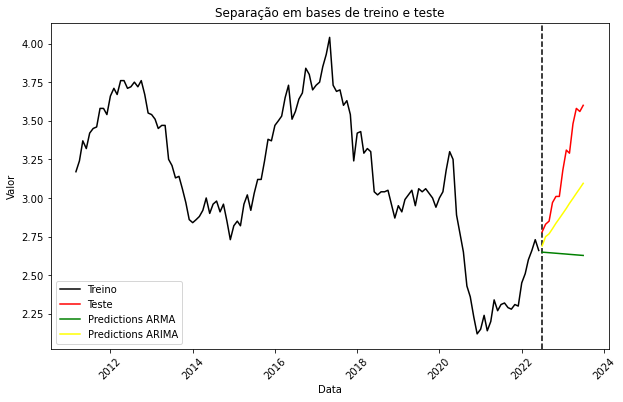

In [24]:
plt.axvline(x =  pd.to_datetime("2022-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.plot(treino, color = "black", label = 'Treino')
plt.plot(teste, color = "red", label = 'Teste')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.title("Separação em bases de treino e teste")
plt.plot(y_pred_out_arma, color='green', label = 'Predictions ARMA')
plt.plot(y_pred_out_arima, color='yellow', label = 'Predictions ARIMA')
plt.legend()
plt.show()

In [25]:
arima_rmse = np.sqrt(mean_squared_error(teste['valor'].values, y_pred_df_arima["Predictions"]))
print("RMSE: ",arima_rmse)

RMSE:  0.3357359064033995


Observando o último gráfico e o valor do RMSE para ARIMA, podemos observar que este modelo fornece melhores resultados em relação ao modelo ARMA. Podemos melhorar ainda mais o modelo se modificamos os parâmetros. Lembre-se que o primeiro parâmetro corresponde ao lagging ou à quantidade de termos auto-regressivos, o segundo parâmetro corresponde à ordem das diferneças e o último, corresponde à quantidade de termos de média móvel.

Assim, podemos modificar os parâmetros de ARIMA para obter melhores previsões:

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


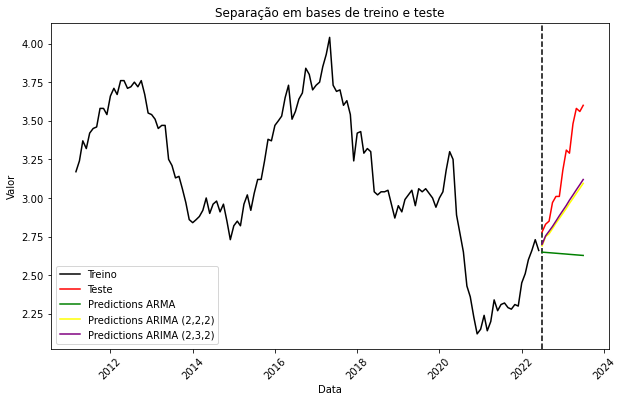

In [26]:
ARIMAmodel_2 = ARIMA(y_treino, order = (2, 3, 2))
ARIMAmodel_2 = ARIMAmodel_2.fit()

y_pred_arima_2 = ARIMAmodel_2.get_forecast(len(teste.index))
y_pred_df_arima_2 = y_pred_arima_2.conf_int(alpha = 0.05) 
y_pred_df_arima_2["Predictions"] = ARIMAmodel_2.predict(start = y_pred_df_arima_2.index[0], end = y_pred_df_arima_2.index[-1])
y_pred_df_arima_2.index = teste.index
y_pred_out_arima_2 = y_pred_df_arima_2["Predictions"] 

plt.axvline(x =  pd.to_datetime("2022-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.plot(treino, color = "black", label = 'Treino')
plt.plot(teste, color = "red", label = 'Teste')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.title("Separação em bases de treino e teste")
plt.plot(y_pred_out_arma, color='green', label = 'Predictions ARMA')
plt.plot(y_pred_out_arima, color='yellow', label = 'Predictions ARIMA (2,2,2)')
plt.plot(y_pred_out_arima_2, color='purple', label = 'Predictions ARIMA (2,3,2)')
plt.legend()
plt.show()

In [27]:
arima_2_rmse = np.sqrt(mean_squared_error(teste['valor'].values, y_pred_df_arima_2["Predictions"]))
print("RMSE: ",arima_2_rmse)

RMSE:  0.31809644609253374


Observa-se que ARIMA(2,3,2) fornece um RMSE menor que ARIMA (2,2,2). Agora, vamos usar ARIMA (5,4,2):

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters

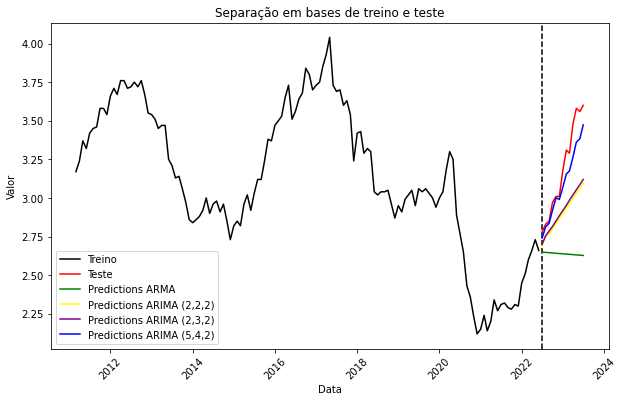

In [28]:
ARIMAmodel_3 = ARIMA(y_treino, order = (5, 4, 2))
ARIMAmodel_3 = ARIMAmodel_3.fit()

y_pred_arima_3 = ARIMAmodel_3.get_forecast(len(teste.index))
y_pred_df_arima_3 = y_pred_arima_3.conf_int(alpha = 0.05) 
y_pred_df_arima_3["Predictions"] = ARIMAmodel_3.predict(start = y_pred_df_arima_3.index[0], end = y_pred_df_arima_3.index[-1])
y_pred_df_arima_3.index = teste.index
y_pred_out_arima_3 = y_pred_df_arima_3["Predictions"] 

plt.axvline(x =  pd.to_datetime("2022-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.plot(treino, color = "black", label = 'Treino')
plt.plot(teste, color = "red", label = 'Teste')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.title("Separação em bases de treino e teste")
plt.plot(y_pred_out_arma, color='green', label = 'Predictions ARMA')
plt.plot(y_pred_out_arima, color='yellow', label = 'Predictions ARIMA (2,2,2)')
plt.plot(y_pred_out_arima_2, color='purple', label = 'Predictions ARIMA (2,3,2)')
plt.plot(y_pred_out_arima_3, color='blue', label = 'Predictions ARIMA (5,4,2)')
plt.legend()
plt.show()

In [29]:
arima_3_rmse = np.sqrt(mean_squared_error(teste['valor'].values, y_pred_df_arima_3["Predictions"]))
print("RMSE: ",arima_3_rmse)

RMSE:  0.12279124660749313


Certamente, ARIMA (5,4,2) fornece previsões bastante aceitáveis em relação aos modelos prévios.

## Seasonal ARIMA (SARIMA)
Podemos levar em conta a sazonalidade de quatro anos observada em dois períodos (entre 2012 e 2016, e entre 2016 e 2020) para usar SARIMA como um potencial modelo preditivo:

In [59]:
SARIMAXmodel = SARIMAX(y_treino, order = (4, 3, 4), seasonal_order=(4,2,4,12))
SARIMAXmodel = SARIMAXmodel.fit()


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


O modelo criado será usado na base de treino para aprendizado:

In [60]:
y_pred_sarima = SARIMAXmodel.get_forecast(len(teste.index))
y_pred_df_sarima = y_pred_sarima.conf_int(alpha = 0.05) 
y_pred_df_sarima["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_sarima.index[0], end = y_pred_df_sarima.index[-1])
y_pred_df_sarima.index = teste.index
y_pred_out_sarima = y_pred_df_sarima["Predictions"] 

Visualizando as previsões:

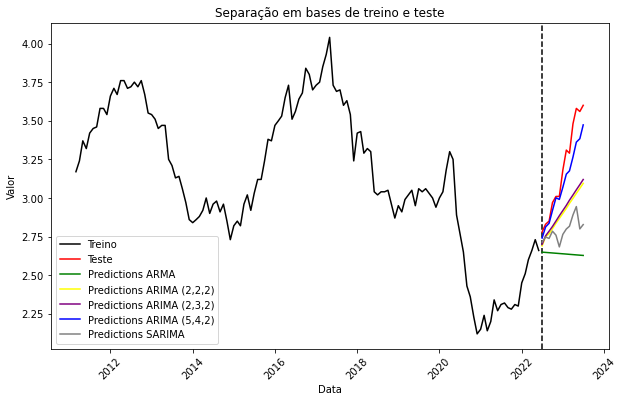

In [63]:
plt.axvline(x =  pd.to_datetime("2022-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.plot(treino, color = "black", label = 'Treino')
plt.plot(teste, color = "red", label = 'Teste')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.title("Separação em bases de treino e teste")
plt.plot(y_pred_out_arma, color='green', label = 'Predictions ARMA')
plt.plot(y_pred_out_arima, color='yellow', label = 'Predictions ARIMA (2,2,2)')
plt.plot(y_pred_out_arima_2, color='purple', label = 'Predictions ARIMA (2,3,2)')
plt.plot(y_pred_out_arima_3, color='blue', label = 'Predictions ARIMA (5,4,2)')
plt.plot(y_pred_out_sarima, color='gray', label = 'Predictions SARIMA')
plt.legend()
plt.show()

In [62]:
sarima_rmse = np.sqrt(mean_squared_error(teste['valor'].values, y_pred_df_sarima["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  0.4650617966346696


## Forecasting para os próximos 12 meses
Certamente, o melhor modelo obtido for SARIMA com os parâmetros (4, 3, 4), seasonal_order=(4,2,4,12). O RMSE fornecido por este modelo é aproximadamente 0.11 na base de teste. Assim, vamos usar este modelo para prever a taxa de inadimplência para os próximos 12 meses, ou seja, para o período entre agosto de 2023 e julho de 2024.

In [34]:
forecasting = SARIMAXmodel.predict(start = pd.to_datetime("2023-08-01", format='%Y-%m-%d'), end = pd.to_datetime("2024-07-01", format='%Y-%m-%d'))

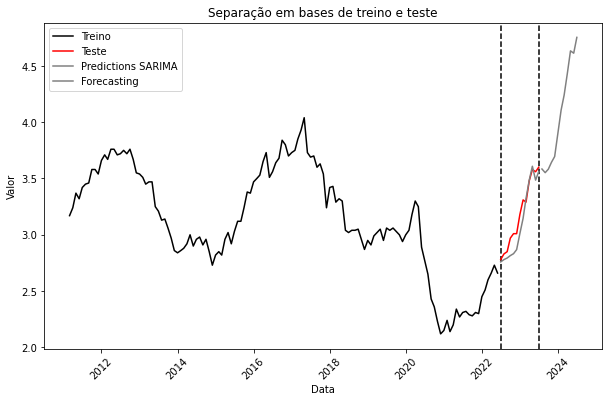

In [35]:
plt.axvline(x =  pd.to_datetime("2022-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.axvline(x =  pd.to_datetime("2023-07-01", format='%Y-%m-%d'), color='k', linestyle='--')
plt.plot(treino, color = "black", label = 'Treino')
plt.plot(teste, color = "red", label = 'Teste')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.title("Separação em bases de treino e teste")
plt.plot(y_pred_out_sarima, color='gray', label = 'Predictions SARIMA')
plt.plot(forecasting, color='gray', label = 'Forecasting')
plt.legend()
plt.show()

Observa-se que as previsões para os próximos 12meses indicam que a taxa aumentaria até atingir máximos históricos. Certamente, devemos usar estas previsões com cuidado no momento de tomar decisões poies é bem conhecido que as previsões estãs mais afastadas da realidad quando mais afastados estamos do presente.

## Conclusão
Neste notebook foi desenvolvido um modelo de forecasting da taxa de inadimplência. A base fornecida está completa e pronta para ser usada em possíveis modelos preditivos. A série temporal foi analisada e estudada para observar padrões de comportamento ao longo do tempo. Foram usados ARMA, ARIMA e SARIMA como possíveis modelos como diferentes parâmetros. SARIMA forneceu os melhores resultados na base de teste com um RMSE de 0.11 y foi escolhido para prever a inadimplência nos próximos 12 meses.